In [33]:
# Load libraries.
import pandas as pd
import numpy as np

# Visualisation libraries.
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [34]:
# Read in the data set
arrests_df = pd.read_csv("UsArrests.csv")
arrests_df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [35]:
# Print the shape of the dataset
print("Shape:", arrests_df.shape)

Shape: (50, 5)


In [36]:
# View column names and data types
print(arrests_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB
None


In [37]:
# View summary of numerical features
print(arrests_df.describe())

         Murder     Assault   UrbanPop       Rape
count  50.00000   50.000000  50.000000  50.000000
mean    7.78800  170.760000  65.540000  21.232000
std     4.35551   83.337661  14.474763   9.366385
min     0.80000   45.000000  32.000000   7.300000
25%     4.07500  109.000000  54.500000  15.075000
50%     7.25000  159.000000  66.000000  20.100000
75%    11.25000  249.000000  77.750000  26.175000
max    17.40000  337.000000  91.000000  46.000000


In [38]:
# Check missing values
print(arrests_df.isnull().sum())

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64


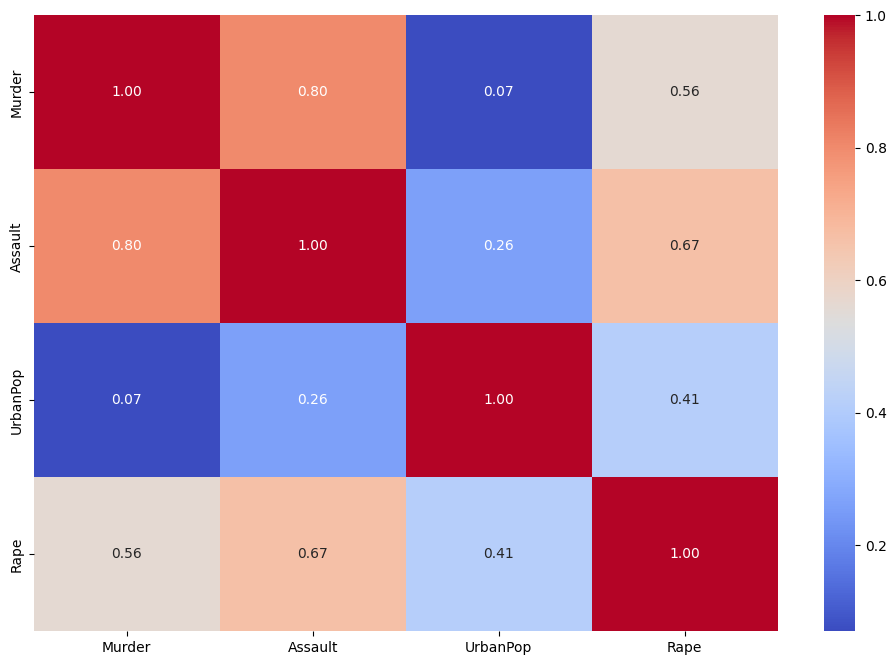

In [39]:
# Create correlation matrix
corr = arrests_df.corr(numeric_only=True)

# Visualise the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [40]:
# The correlation matrix shows the highest correlation (0.8) between assault and murder. 
# This demonstrates a positive relationship between these variables which means that as assault rates increase, so do murder rates and vice versa.
# Urban population has the smallest correlation between the other variables: assault, murder and rape.
# However, the correlation between the variables: assault, murder and rape are relatively high because they are all greater than 0.5.

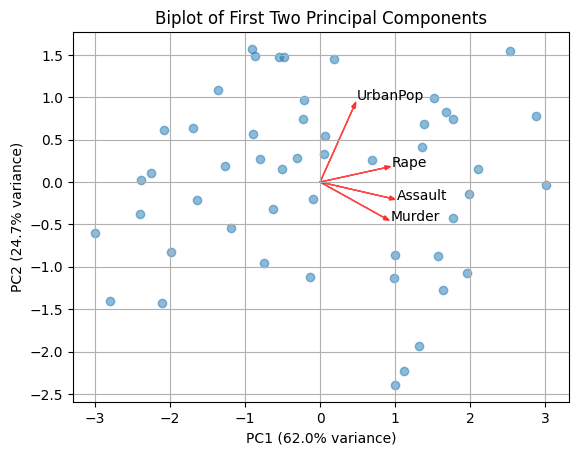

In [41]:
# Assign X variables
X = arrests_df.drop(columns=['City']) 

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_scaled)

# Convert to DataFrame for convenience
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Plot the points
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.5)

# Get numeric columns from arrests_df
numeric_cols = arrests_df.select_dtypes(include=np.number).columns

# Plot the vectors
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(numeric_cols):
    plt.arrow(0, 0, loadings[i,0], loadings[i,1],
              color='red', alpha=0.7, head_width=0.05)
    plt.text(loadings[i,0]*1.1, loadings[i,1]*1.1, feature, color='black')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.title("Biplot of First Two Principal Components")
plt.grid(True)
plt.show()

In [42]:
# PC1 explains most of the variance (62%) and PC2 explains the second most variance (24.7%).
# Looking at the arrows direction we can see that Murder and Assault are strongly correlated and have a positive correlation. 
# Rape is positively correlated with Assault and Murder but the relationship is slightly weaker.
# Urban population has a low correlation with Assault and Murder.
# Urban population is positively correlated with Rape, but it has a relatively weak correlation.

In [47]:
# The choice for the number of principal components is 2.
# This is because PC1 and PC2 capture the majority of the variability with 86.7%.
# Adding more PCs will likely explain very little variance so keeping 2 PCs will ensure analysis is straightforward.

C:\Users\isabe\AppData\Local\Temp\ipykernel_29188\2298199118.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


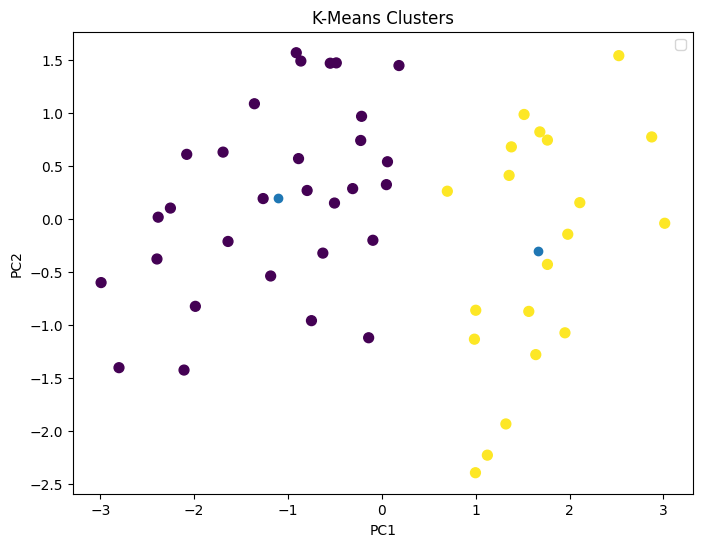

Silhouette Score (KMeans): 0.47580314770755605


In [55]:
# Use the first 2 principal components for clustering
X_cluster = df_pca[['PC1', 'PC2']].values

# Decide on the number of clusters 
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(X_cluster)

# Add labels to your dataframe
df_pca['KMeans_Cluster'] = labels_kmeans

# Visualize clusters
plt.figure(figsize=(8,6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=labels_kmeans, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clusters')
plt.legend()
plt.show()

# Assess with silhouette score
sil_score = silhouette_score(X_cluster, labels_kmeans)
print("Silhouette Score (KMeans):", sil_score)

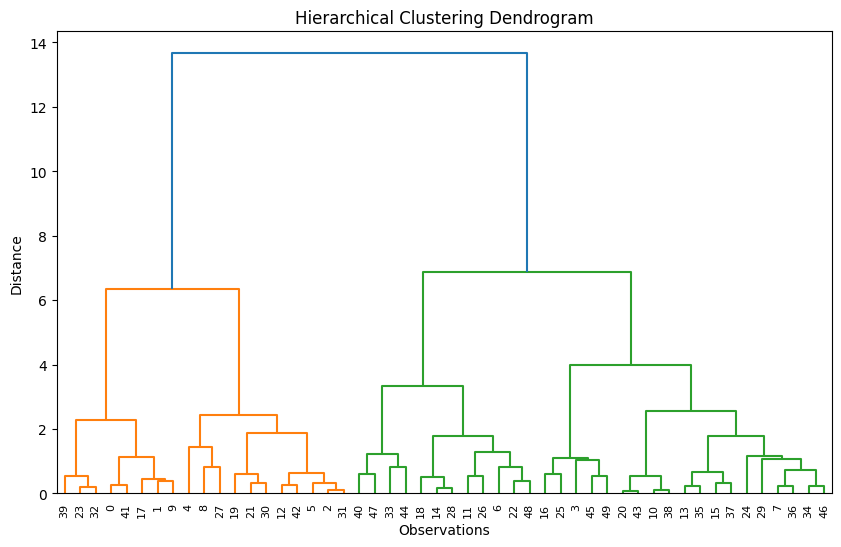

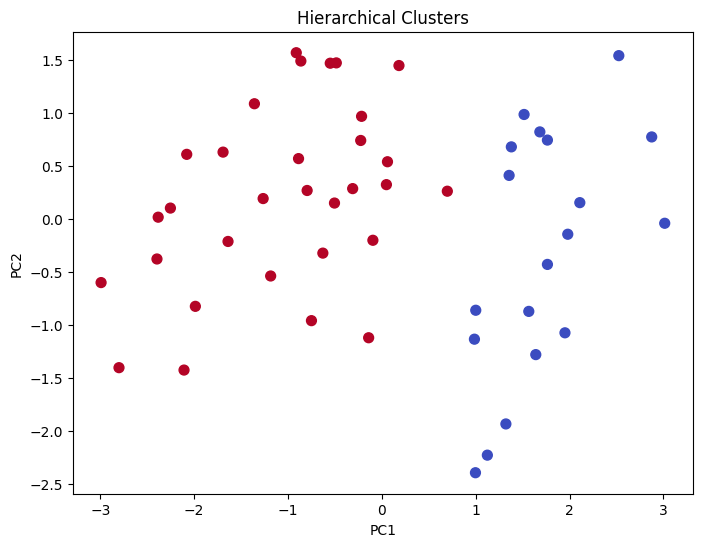

Silhouette Score (Hierarchical): 0.4698907209558827


In [54]:
# Create linkage matrix
Z = linkage(X_cluster, method='ward')

# Plot dendrogram
plt.figure(figsize=(10,6))
dendrogram(Z, labels=df_pca.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.show()

# Cut dendrogram to form clusters (e.g., 3 clusters)
labels_hier = fcluster(Z, t=2, criterion='maxclust')
df_pca['Hierarchical_Cluster'] = labels_hier

# Visualize clusters
plt.figure(figsize=(8,6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=labels_hier, cmap='coolwarm', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Hierarchical Clusters')
plt.show()

# Assess with silhouette score
score = silhouette_score(X_cluster, labels_hier)
print("Silhouette Score (Hierarchical):", score)

In [ ]:
# The silhouette scores for both clustering techniques are moderate (not very high) which indicates clusters are well seperated but with some overlap.
# Both clustering techniques produce similar results but KMeans outperforms the Hierarchical cluster slightly, making KMeans slightly more preferable.
# These results could be because the data structure is not perfectly clusterable.